In [1]:
import sys
import time
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sfp_nsdsyn as sfp
import sfp_nsdsyn.visualization as vis
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

# Data information

In [2]:
results_dir='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/derivatives/derivatives_HPC/results_2D'
dataset = 'nsdsyn'
stat = 'mean'
full_ver= [True]
sn_list = np.arange(1,9)
lr_rate = [0.0005]
max_epoch = [30000]
roi_list = ['V1']
fig_dir='/Users/jh7685/Dropbox/NYU/Projects/SF/MyResults/2D_tuning_prediction'

# Formula Pv

\begin{aligned}
p_v=\left[a r_v+b\right][1 & +p_1 \cos \left(2 \theta_l\right)+p_2 \cos \left(4 \theta_l\right) \\
& +p_3 \cos \left(2\left(\theta_l-\theta_v\right)\right) \\
& \left.+p_4 \cos \left(4\left(\theta_l-\theta_v\right)\right)\right]
\end{aligned}

# Load in final 2D model parameters (a,b,p1,p2,p3,p4,a1,& a2)

We're going to find what preferred period of a synthetic voxel has, based on this model parameters.

In [3]:
all_model_history = sfp.two_dimensional_model.load_history_df_subj(results_dir, dataset, stat, full_ver, sn_list, lr_rate, max_epoch, 'model', roi_list)
model_params = all_model_history.query('epoch == @max_epoch[0]-1')
display(model_params)

,epoch,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,dset,lr_rate,max_epoch,full_ver,subj,vroinames
29999,29999,2.444468,0.138925,0.216342,-0.160678,-0.045313,-0.114538,0.032326,0.040104,-0.072530,nsdsyn,0.0005,30000,True,subj01,V1
59999,29999,2.019560,0.123717,0.090956,-0.015425,-0.064137,0.147342,-0.048341,-0.006036,0.034134,nsdsyn,0.0005,30000,True,subj02,V1
89999,29999,2.579941,0.051193,0.111091,0.138689,-0.150462,0.163207,-0.040287,-0.021408,0.024107,nsdsyn,0.0005,30000,True,subj03,V1
119999,29999,1.975181,0.179895,0.122055,0.122718,-0.135793,0.099535,-0.013634,0.046516,0.028437,nsdsyn,0.0005,30000,True,subj04,V1
149999,29999,2.622015,0.107188,0.135675,-0.132166,-0.164759,0.016274,-0.027864,0.043370,0.011752,nsdsyn,0.0005,30000,True,subj05,V1
179999,29999,2.087170,0.166967,0.221159,0.159871,-0.173341,0.057587,0.040253,0.034356,-0.021300,nsdsyn,0.0005,30000,True,subj06,V1
209999,29999,2.249080,0.109479,0.093930,0.142332,-0.174437,0.123923,-0.144933,-0.023559,-0.029919,nsdsyn,0.0005,30000,True,subj07,V1
239999,29999,2.581744,0.199068,0.093001,-0.311129,-0.185420,0.065450,-0.000913,0.109359,0.023116,nsdsyn,0.0005,30000,True,subj08,V1


#  Load in stimulus information

I'm loading in the stimulus information dataframe because I would need at least one w_r and w_a combination for each stimulus class. I wouldn't need all of them (e.g. different frequency levels), since this will be only needed for calculating theta_l, which takes in a ratio between w_a and w_r.

In [4]:
stim_info = pd.read_csv('/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsdsynthetic_sf_stim_description.csv')
stim_info = stim_info[['names','names_idx','w_r','w_a','phase','class_idx','freq_lvl']]
stim_info = stim_info.drop_duplicates('names').drop(columns=['names_idx','phase','class_idx','freq_lvl'])
display(stim_info)

,names,w_r,w_a
0,pinwheel,0.0,6.0
24,forward spiral,4.0,4.0
48,annulus,6.0,0.0
72,reverse spiral,4.0,-4.0
96,intermediate 1,14.0,34.0
100,intermediate 2,34.0,14.0
104,intermediate 3,34.0,-14.0
108,intermediate 4,14.0,-34.0


# 1. Use all orientation & angle combinations
One way to calculate preferred period (Pv) is to make all possible combinations of local orientation and retinotopic angle combinations. The process is a lot similar to simulations in that we're now making a bunch of imaginary voxels, except that the calculation is based on the actual found model parameters.

1. Make synthetic eccentricity dataframe
2. Calculate theta_l based on the synthetic eccentricity & w_r & w_a for each stimulus conditions
3. Make synthetic orientation dataframe based on the 2nd dataframe
4. average over orientation

## 1. Make continuous eccentricities
Here I only make 3 eccentricities as an example.


In [5]:
all_ecc_model_params = vis.plot_2D_model_results.merge_continuous_values_to_the_df(stim_info, val_range=(0,5), repeat=3, col_name='eccentricity')
display(all_ecc_model_params.head())
all_ecc_model_params.shape

,names,w_r,w_a,eccentricity
0,pinwheel,0.0,6.0,0.0
1,forward spiral,4.0,4.0,0.0
2,annulus,6.0,0.0,0.0
3,reverse spiral,4.0,-4.0,0.0
4,intermediate 1,14.0,34.0,0.0


(24, 4)

## 2. Make continuous retinotopic angles

In [8]:
all_angle_model_params = vis.plot_2D_model_results.merge_continuous_values_to_the_df(all_ecc_model_params, val_range=(0,360), repeat=360, col_name='angle')
display(all_angle_model_params.head())
print(all_angle_model_params.shape)

,names,w_r,w_a,eccentricity,angle
0,pinwheel,0.0,6.0,0.0,0.0
1,forward spiral,4.0,4.0,0.0,0.0
2,annulus,6.0,0.0,0.0,0.0
3,reverse spiral,4.0,-4.0,0.0,0.0
4,intermediate 1,14.0,34.0,0.0,0.0


(8640, 5)


## 3. Make continuous theta_l

In [9]:
synthetic_stim_df = sfp.preprocessing._calculate_local_orientation(all_angle_model_params)
display(synthetic_stim_df)

,names,w_r,w_a,eccentricity,angle,local_ori
0,pinwheel,0.0,6.0,0.0,0.0,1.570796
1,forward spiral,4.0,4.0,0.0,0.0,0.785398
2,annulus,6.0,0.0,0.0,0.0,0.000000
3,reverse spiral,4.0,-4.0,0.0,0.0,2.356194
4,intermediate 1,14.0,34.0,0.0,0.0,1.180189
...,...,...,...,...,...,...
8635,reverse spiral,4.0,-4.0,5.0,360.0,2.356194
8636,intermediate 1,14.0,34.0,5.0,360.0,1.180189
8637,intermediate 2,34.0,14.0,5.0,360.0,0.390607
8638,intermediate 3,34.0,-14.0,5.0,360.0,2.750986


In [11]:
synthetic_stim_df['angle'] = np.deg2rad(synthetic_stim_df['angle'])
synthetic_stim_df.tail()

,names,w_r,w_a,eccentricity,angle,local_ori
8635,reverse spiral,4.0,-4.0,5.0,6.283185,2.356194
8636,intermediate 1,14.0,34.0,5.0,6.283185,1.180189
8637,intermediate 2,34.0,14.0,5.0,6.283185,0.390607
8638,intermediate 3,34.0,-14.0,5.0,6.283185,2.750986
8639,intermediate 4,14.0,-34.0,5.0,6.283185,1.961403


Just got curious if we have a kinda uniform distribution across local orientations... why do we have more vertical orientation than other orientations?

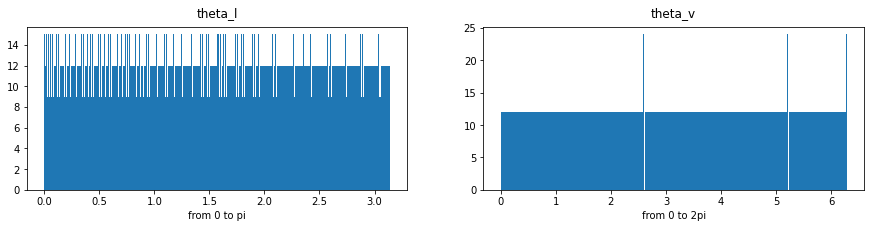

In [12]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
stim_class = ['pinwheel','forward spiral', 'reverse spiral', 'annulus']
axes[0].hist(synthetic_stim_df.query('names in @stim_class').local_ori, np.linspace(0,np.pi, 360))
axes[0].set_title('theta_l', pad=10)
axes[0].set_xlabel('from 0 to pi')
axes[1].hist(synthetic_stim_df.query('names in @stim_class').angle, np.linspace(0,np.pi*2, 360))
axes[1].set_title('theta_v', pad=10)
axes[1].set_xlabel('from 0 to 2pi')
plt.show()

In [13]:
synthetic_stim_df.query('local_ori == 0')

,names,w_r,w_a,eccentricity,angle,local_ori
2,annulus,6.0,0.0,0.0,0.000000,0.0
10,annulus,6.0,0.0,2.5,0.000000,0.0
18,annulus,6.0,0.0,5.0,0.000000,0.0
8618,annulus,6.0,0.0,0.0,6.283185,0.0
8626,annulus,6.0,0.0,2.5,6.283185,0.0
8634,annulus,6.0,0.0,5.0,6.283185,0.0


## 4. Calculate preferred period

In [14]:
start = time.time()
all_subj_df = pd.DataFrame({})
for sn in sn_list:
    subj = sfp.utils.sub_number_to_string(sn, dataset=dataset)
    subj_df = synthetic_stim_df.copy()
    subj_df['subj'] = subj
    subj_df['Pv'] = subj_df.apply(lambda row: sfp.two_dimensional_model.get_Pv_row(row, model_params.query('subj == @subj')), axis=1)
    all_subj_df = all_subj_df.append(subj_df, ignore_index=True)

end = time.time()
print(f'elapsed time: {end - start}')
print(all_subj_df.shape)

elapsed time: 153.05674076080322
(69120, 8)


In [15]:
all_subj_df.query('eccentricity == 0 & names == "pinwheel"')

,names,w_r,w_a,eccentricity,angle,local_ori,subj,Pv
0,pinwheel,0.0,6.0,0.0,0.000000,1.570796,subj01,0.273073
24,pinwheel,0.0,6.0,0.0,0.017502,1.588298,subj01,0.273076
48,pinwheel,0.0,6.0,0.0,0.035004,1.605800,subj01,0.273084
72,pinwheel,0.0,6.0,0.0,0.052506,1.623302,subj01,0.273097
96,pinwheel,0.0,6.0,0.0,0.070008,1.640804,subj01,0.273115
...,...,...,...,...,...,...,...,...
69000,pinwheel,0.0,6.0,0.0,6.213178,1.500789,subj08,0.098909
69024,pinwheel,0.0,6.0,0.0,6.230680,1.518291,subj08,0.098740
69048,pinwheel,0.0,6.0,0.0,6.248181,1.535793,subj08,0.098618
69072,pinwheel,0.0,6.0,0.0,6.265683,1.553294,subj08,0.098545



## Plot preferred period as a function of eccentricity

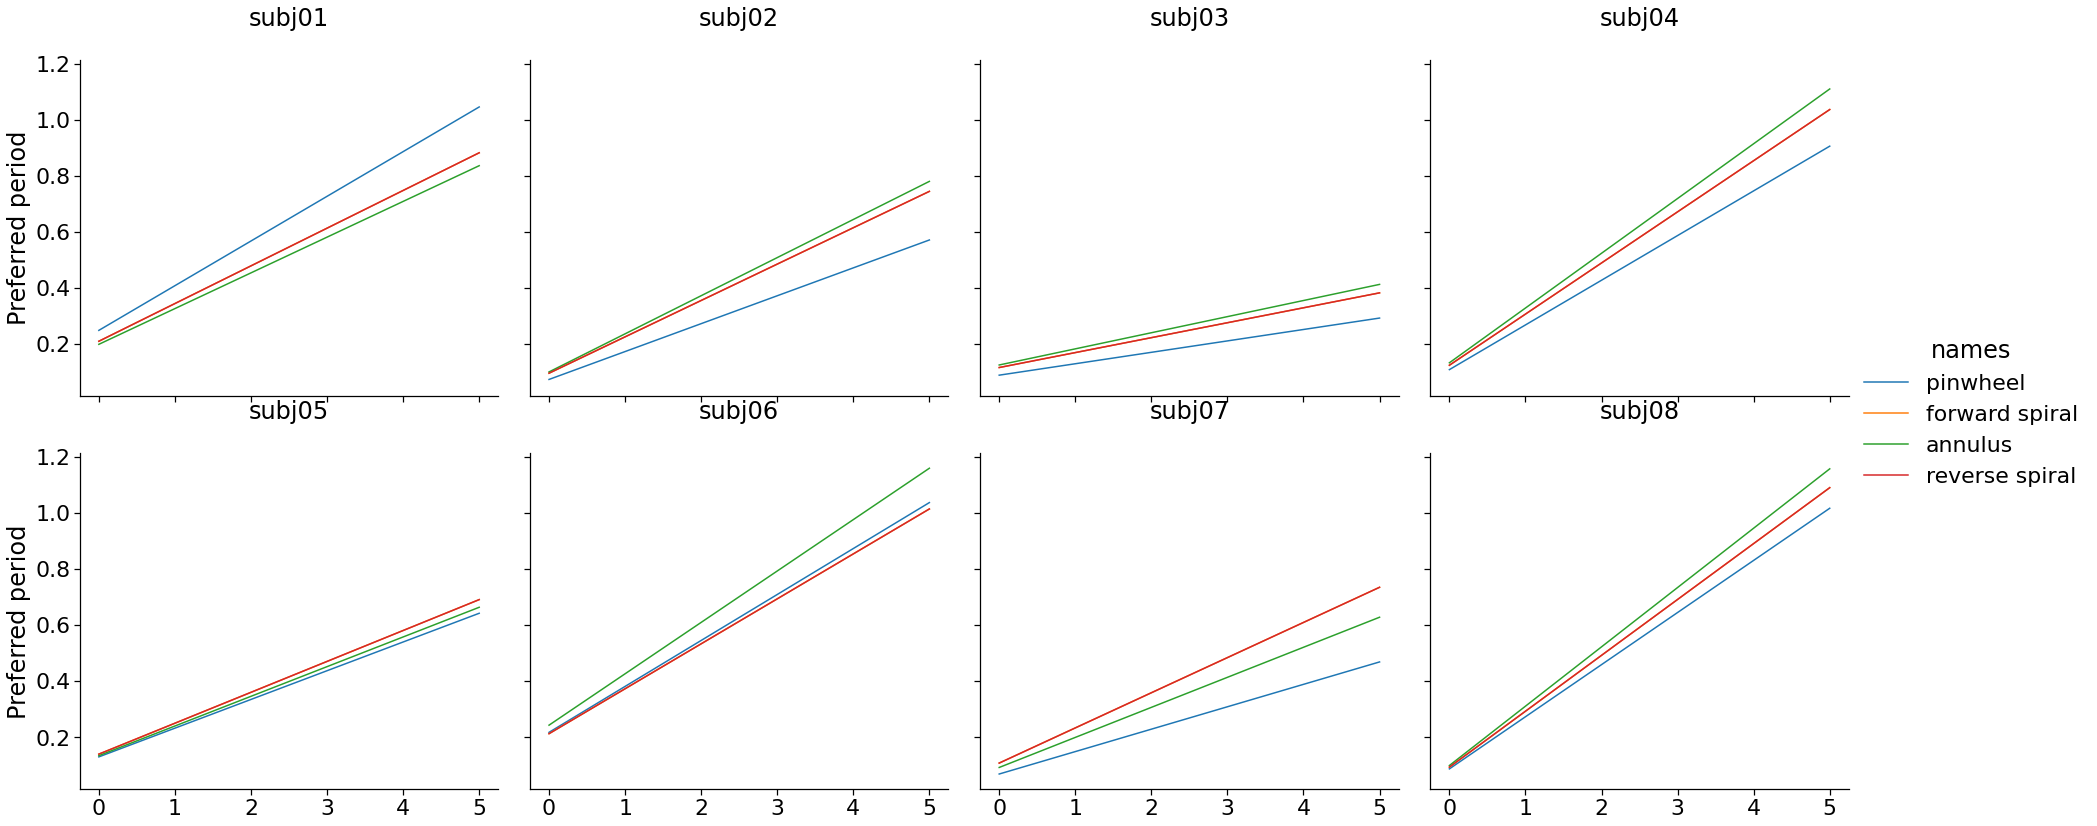

In [16]:
vis.plot_2D_model_results.plot_preferred_period(all_subj_df.query('names in @stim_class'))

## Preferred period as a function of retinotopic angle (When eccentricity is 2.5 deg)

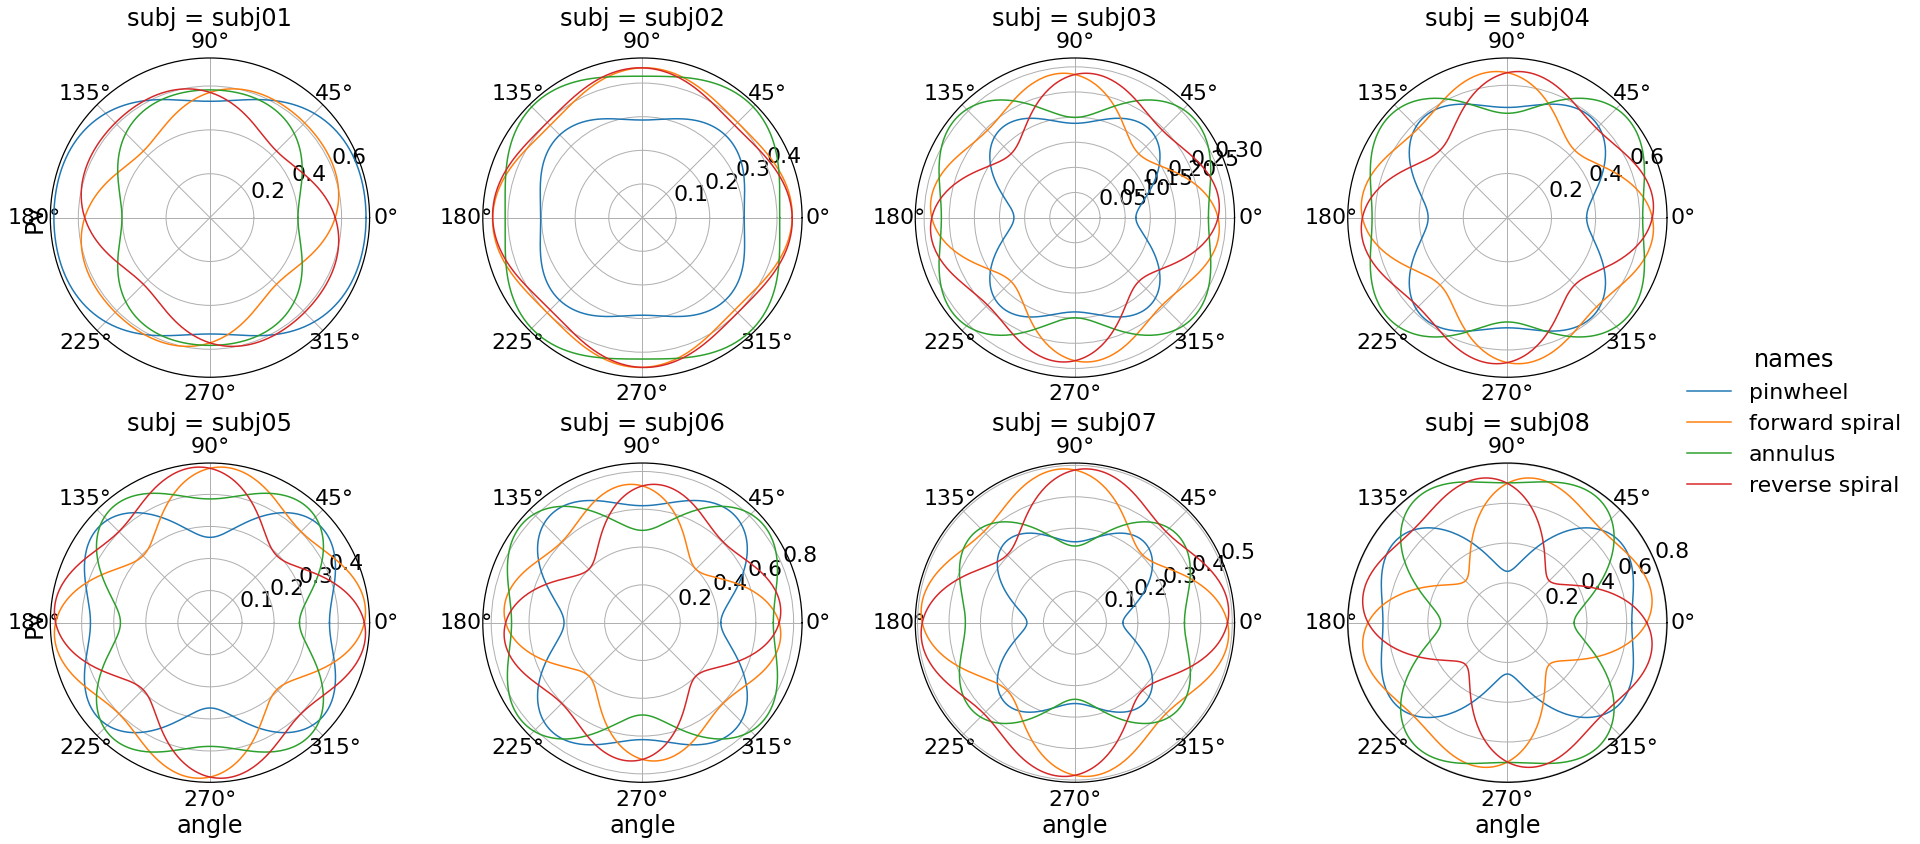

In [19]:
vis.plot_2D_model_results.polarplot_preferred_period(all_subj_df.query('names in @stim_class & eccentricity == 2.5'))

## Preferred period as a function of retinotopic angle (When eccentricity is 0 deg)


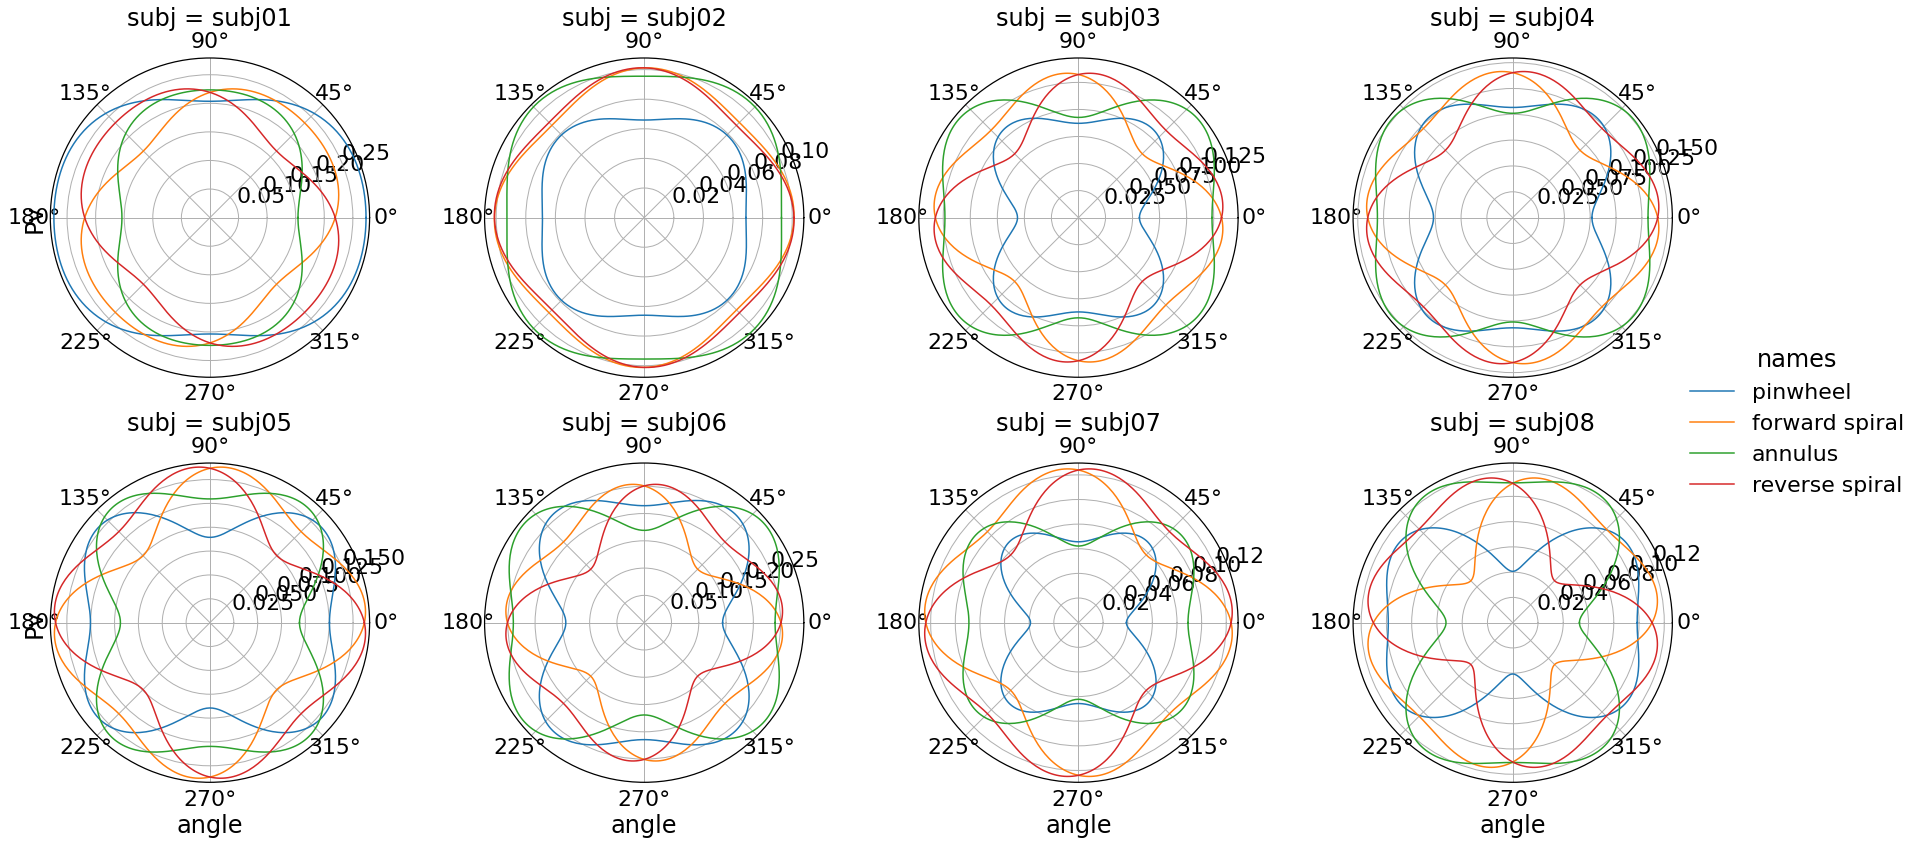

In [20]:
vis.plot_2D_model_results.polarplot_preferred_period(all_subj_df.query('names in @stim_class & eccentricity == 0'))

In [21]:
ss_all_ecc_model_params = vis.plot_2D_model_results.merge_continuous_values_to_the_df(stim_info, val_range=(0,5), repeat=3, col_name='eccentricity')
ss_all_angle_model_params = vis.plot_2D_model_results.merge_continuous_values_to_the_df(ss_all_ecc_model_params, val_range=(0,180), repeat=4, col_name='angle', endpoint=False)
ss_synthetic_stim_df = sfp.preprocessing._calculate_local_orientation(ss_all_angle_model_params)
display(synthetic_stim_df)
ss_synthetic_stim_df['angle'] = np.deg2rad(ss_synthetic_stim_df['angle'])
ss_all_subj_df = pd.DataFrame({})
for sn in sn_list:
    subj = sfp.utils.sub_number_to_string(sn, dataset=dataset)
    ss_subj_df = ss_synthetic_stim_df.copy()
    ss_subj_df['subj'] = subj
    ss_subj_df['Pv'] = ss_subj_df.apply(lambda row: sfp.two_dimensional_model.get_Pv_row(row, model_params.query('subj == @subj')), axis=1)
    ss_all_subj_df = ss_all_subj_df.append(ss_subj_df, ignore_index=True)


,names,w_r,w_a,eccentricity,angle,local_ori
0,pinwheel,0.0,6.0,0.0,0.000000,1.570796
1,forward spiral,4.0,4.0,0.0,0.000000,0.785398
2,annulus,6.0,0.0,0.0,0.000000,0.000000
3,reverse spiral,4.0,-4.0,0.0,0.000000,2.356194
4,intermediate 1,14.0,34.0,0.0,0.000000,1.180189
...,...,...,...,...,...,...
8635,reverse spiral,4.0,-4.0,5.0,6.283185,2.356194
8636,intermediate 1,14.0,34.0,5.0,6.283185,1.180189
8637,intermediate 2,34.0,14.0,5.0,6.283185,0.390607
8638,intermediate 3,34.0,-14.0,5.0,6.283185,2.750986


# What happens if we use only a set of orientations like Billys

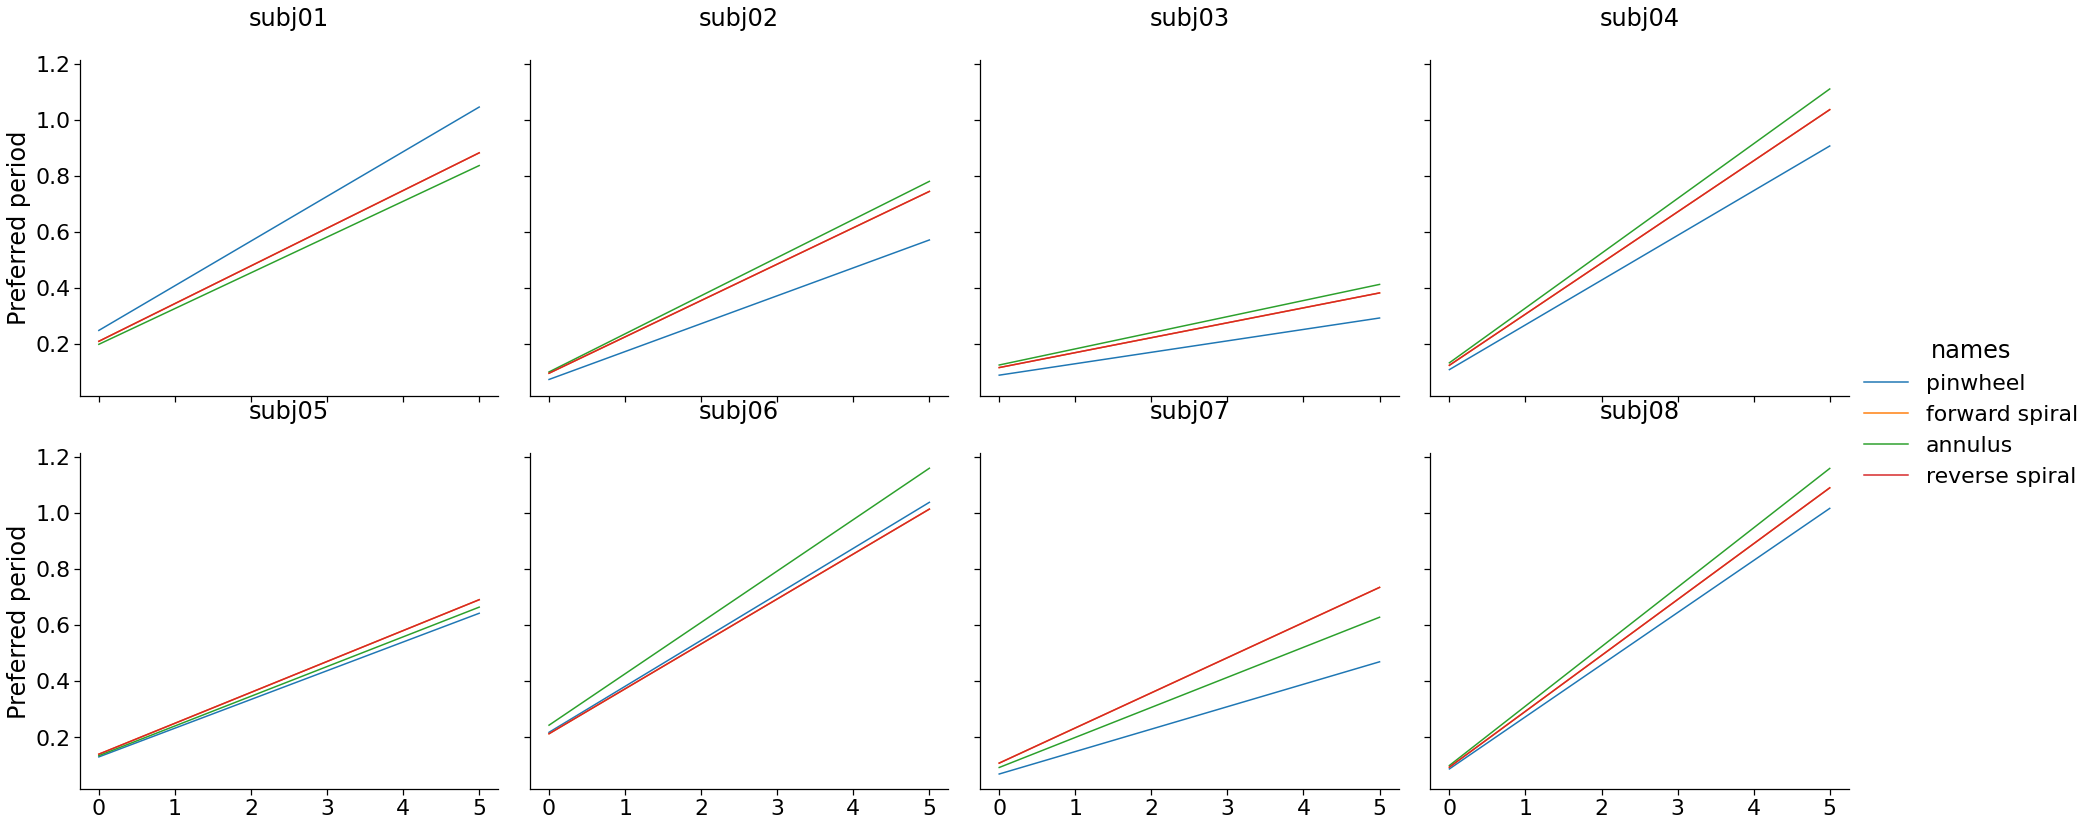

In [22]:
vis.plot_2D_model_results.plot_preferred_period(ss_all_subj_df.query('names in @stim_class'))


# 2. Take derivatives and find where the f'(theta_l, theta_v) == 0 and apply those values only

In [185]:
test_df = synthetic_stim_df[['angle','local_ori']]
X, Y = np.meshgrid(np.linspace(0,2*np.pi, 100), np.linspace(0,np.pi, 100))
Z = (1 + model_params.p_1.item() * np.cos(2 * Y) +
              model_params.p_2.item() * np.cos(4 * Y) +
              model_params.p_3.item() * np.cos(2 * (Y - X)) +
              model_params.p_4.item() * np.cos(4 * (Y - X)))

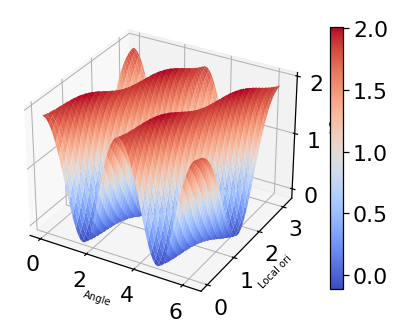

In [198]:
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(111, projection='3d')
surf_data = ax.plot_surface(X, Y, Z, cmap='coolwarm')
fig.colorbar(surf_data, shrink=0.5)
ax.set_xlabel('Angle', fontsize=10)
ax.set_ylabel('Local ori', fontsize=10)
ax.set_zlabel('part Pv', fontsize=10)
plt.tight_layout()